In [1]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import os

from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import numpy as np
import torch as t

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
from torch import nn, optim
from torch.nn import functional as F
from tqdm.notebook import tqdm

In [2]:
@dataclass
class CisConfig:
    n_instances: int = 1
    n_feat: int = 2
    n_hidden: int = 4
    act_fn: List[Callable] = field(default_factory=lambda: [F.relu, F.relu])
    #b1: str | Float[t.Tensor, "inst hid"] = field(default_factory=lambda: "0")
    #b2: str | Float[t.Tensor, "inst hid"] = field(default_factory=lambda: "0")
    optimizer: Callable = t.optim.Adam
    fx: Callable = F.relu

    def __post_init__(self):
        """Ensure attribute values are valid."""
        pass

In [18]:
class Lucius(nn.Module):
    """Lucius toy model."""

    W1: Float[t.Tensor, "inst feat hid"]
    W2: Float[t.Tensor, "inst hid feat"]

    def __init__(self, cfg: CisConfig):
        """Initializes model params."""
        super().__init__()
        self.cfg = cfg

        # Model Weights
        self.W1 = nn.Parameter(nn.init.xavier_normal_(t.empty(cfg.n_instances, cfg.n_feat, cfg.n_hidden)))
        self.W2 = nn.Parameter(nn.init.xavier_normal_(t.empty(cfg.n_instances, cfg.n_hidden, cfg.n_feat)))    

    def gen_batch(self, batch_sz: int) -> t.Tensor:
        """Generates a batch of data (sparse feature vals on [-1, 1]) with instances.
        
        Returns:
            Tensor of shape (batch_sz, n_instances, n_feat) with one random activated
            feature per instance.
        """
        # Create zero tensor with instances dimension
        x = t.zeros(batch_sz, self.cfg.n_instances, self.cfg.n_feat)
        
        # Generate random positions for each batch and instance
        active_positions = t.randint(0, self.cfg.n_feat, (batch_sz, self.cfg.n_instances))
        
        # Generate random values between -1 and 1 for each batch and instance
        #active_values = t.rand(batch_sz, self.cfg.n_instances) * 2 - 1
        active_values = t.randint(0, 2, (batch_sz, self.cfg.n_instances)) * 2.0 - 1
        
        # Create index tensors for vectorized assignment
        batch_idx = t.arange(batch_sz).view(-1, 1).expand(-1, self.cfg.n_instances)
        instance_idx = t.arange(self.cfg.n_instances).expand(batch_sz, -1)
        
        # Vectorized assignment using advanced indexing
        x[batch_idx, instance_idx, active_positions] = active_values
        
        return x

    def forward(self, x: Float[t.Tensor, "batch inst feat"]) -> Float[t.Tensor, "batch inst feat"]:
        """Runs a forward pass through model returning the loss."""

        # Hidden layer
        h = einsum(x, self.W1, "batch inst feat, inst feat hid -> batch inst hid")
        h = self.cfg.act_fn[0](h)

        # Output layer
        y = einsum(h, self.W2, "batch inst hid, inst hid feat -> batch inst feat")
        #y = self.cfg.act_fn[1](y + self.b2)
        #y = self.cfg.act_fn[0](y)

        return y

    def calculate_loss(self,  x: Float[t.Tensor, "batch inst feat"], y: Float[t.Tensor, "batch inst feat"]) -> Float[t.Tensor, ""]:

        y_true = self.cfg.fx(x)
        #return self.weighted_L1(y_true, y)
        #return self.zero_out_inactive(y_true, y)
        return self.weighted_mse(y_true, y)
    
        # non_zero_mask = (x != 0)
        # zero_mask = (x == 0)
        
        # y_diff = y[non_zero_mask] - y_true[non_zero_mask]
        
        # loss = t.mean(t.abs(y_diff))
        # rest_mult = 2.0
        # loss += rest_mult * t.mean(t.abs(y[zero_mask] - y_true[zero_mask]))
        # return loss
    
    # def weighted_binary_cross_entropy(self, y_true, y_pred, active_weight=10.0, inactive_weight=1.0):
    #     # print(y_true.shape)
    #     # print(y_pred.shape)
    #     # print(t.min(y_true), t.max(y_true))
    #     # print(t.min(y_pred), t.max(y_pred))
    #     weights = t.where(y_true == 1, active_weight, inactive_weight)
    #     y_pred_sigmoid = t.sigmoid(y_pred)
    #     bce = F.binary_cross_entropy(y_pred_sigmoid, y_true, reduction='none')
    #     weighted_bce = weights * bce
    #     return t.mean(weighted_bce)
    
    # def zero_out_inactive(self, y_true, y_pred):
    #     thres = 0.01
    #     relative_thres = thres * y_true
    #     cleaned_pred = t.relu(y_pred - relative_thres) + relative_thres
    #     mse = (y_true - cleaned_pred) ** 2
    #     return t.mean(mse)

    def weighted_mse(self, y_true, y_pred, active_weight=10, inactive_weight=1.0):
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        mse = (y_true - y_pred) ** 2
        weighted_mse = weights * mse
        return t.mean(weighted_mse)

    def weighted_L1(self, y_true, y_pred, active_weight=10, inactive_weight=1.0):
        weights = t.where(y_true == 1, active_weight, inactive_weight)
        L1 = t.abs(y_true - y_pred)
        weighted_L1 = weights * L1
        return t.mean(weighted_L1)

    def optimize(
        self, optimizer: t.optim.Optimizer, batch_sz: int, steps: int, logging_freq: int
    ):
        """Optimizes the model."""

        losses = []
        pbar = tqdm(range(steps), desc="Training")

        for step in pbar:
            x = self.gen_batch(batch_sz)
            y = self.forward(x)
            optimizer.zero_grad()
            loss = self.calculate_loss(x, y)
            loss.backward()
            optimizer.step()
            # Log progress
            if step % logging_freq == 0 or (step + 1 == steps):
                losses.append(loss.item())
                pbar.set_postfix({"loss": f"{loss.item():.4f}"})
            # if loss <= 10e-4:
            #     print(loss)
            #     break

        return losses

In [19]:
n_instances=1
n_feat = 100
n_hidden = 50

config = CisConfig(n_instances=n_instances, n_feat=n_feat, n_hidden=n_hidden)

In [20]:
model = Lucius(config)
batch_sz = 128
steps = 10000
logging_freq = steps // 10

model.optimize(t.optim.Adam(model.parameters()), batch_sz, steps, logging_freq)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.04610653221607208,
 0.005066508427262306,
 0.004213360138237476,
 0.004395646974444389,
 0.004263615235686302,
 0.004567816387861967,
 0.004438393283635378,
 0.004509293008595705,
 0.0049343472346663475,
 0.004377719014883041,
 0.004922091495245695]

86
[tensor(0.0103), tensor(0.0093), tensor(0.0107), tensor(0.0078), tensor(0.0097), tensor(0.0092), tensor(0.0085), tensor(0.0088), tensor(0.0093), tensor(0.0083), tensor(0.0089), tensor(0.0098), tensor(0.0095), tensor(0.0087), tensor(0.0100), tensor(0.0082), tensor(0.0093), tensor(0.0092), tensor(0.0080), tensor(0.0089), tensor(0.0084), tensor(0.0093), tensor(0.0087), tensor(0.0085), tensor(0.0085), tensor(0.0092), tensor(0.0100), tensor(0.0083), tensor(0.0086), tensor(0.0082), tensor(0.0090), tensor(0.0105), tensor(0.0093), tensor(0.0105), tensor(0.0097), tensor(0.0082), tensor(0.0098), tensor(0.0089), tensor(0.0092), tensor(0.0094), tensor(0.0091), tensor(0.0105), tensor(0.0086), tensor(0.0084), tensor(0.0096), tensor(0.0104), tensor(0.0090), tensor(0.0095), tensor(0.0077), tensor(0.0084), tensor(0.0088), tensor(0.0080), tensor(0.0094), tensor(0.0093), tensor(0.0084), tensor(0.0091), tensor(0.0090), tensor(0.0087), tensor(0.0097), tensor(0.0093), tensor(0.0105), tensor(0.0103), tens

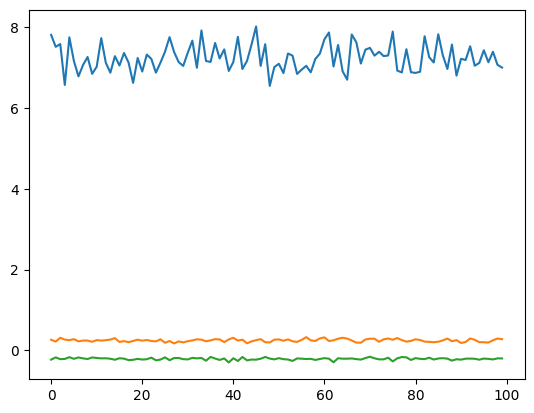

In [41]:
count, losses_sep, losses_stat = count_represented_features(n_feat, model, threshold=0.1)
print(count)
print(losses_sep)
print(losses_stat)
sums = [losses_stat[i][3] for i in range(n_feat)]
maxs = [losses_stat[i][0] for i in range(n_feat)]
mins = [losses_stat[i][1] for i in range(n_feat)]
big_noise = [losses_stat[i][2] for i in range(n_feat)]
plt.plot(sums)
plt.plot(maxs)
plt.plot(mins)
print(big_noise)
#print(np.mean(losses_sep))

C:\Users\gigle\AppData\Local\Temp\ipykernel_42420\3293248400.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)


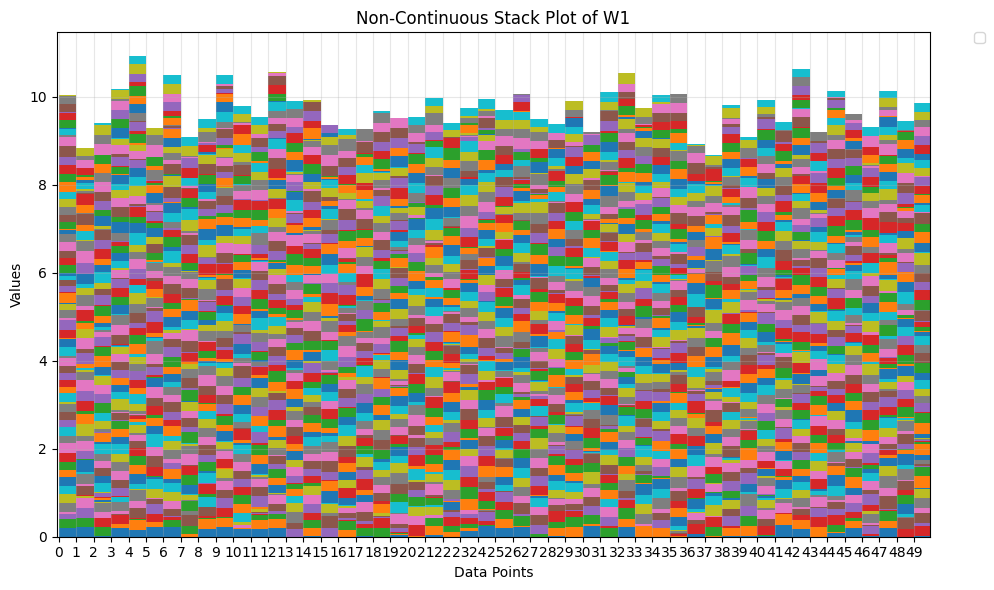

In [36]:
plot_polysemanticity(model.W1.detach().squeeze(), transpose=False)

In [23]:
W1 = model.W1[0].detach().squeeze().clone()
W2 = model.W2[0].detach().squeeze().clone()


torch.Size([100, 50])
(tensor([20, 23, 22, 22, 20, 25, 21, 15, 22, 19, 22, 19, 22, 22, 21, 22, 27, 19,
        26, 20, 22, 21, 22, 25, 18, 22, 24, 25, 22, 26, 20, 21, 21, 24, 23, 20,
        22, 21, 27, 19, 20, 18, 23, 22, 23, 23, 20, 25, 21, 23, 18, 17, 19, 25,
        21, 19, 26, 23, 20, 19, 21, 27, 22, 20, 21, 19, 21, 23, 21, 22, 20, 22,
        21, 18, 22, 20, 22, 20, 25, 21, 21, 23, 22, 19, 22, 22, 20, 22, 23, 24,
        20, 21, 21, 24, 23, 17, 22, 22, 22, 27]), tensor([50, 35, 43, 48, 49, 40, 45, 38, 41, 45, 43, 41, 50, 48, 47, 39, 42, 42,
        44, 40, 43, 46, 44, 38, 44, 44, 44, 37, 45, 48, 41, 45, 50, 43, 47, 45,
        37, 35, 45, 40, 45, 40, 51, 40, 48, 45, 41, 41, 39, 43]))


C:\Users\gigle\AppData\Local\Temp\ipykernel_42420\4263092405.py:29: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



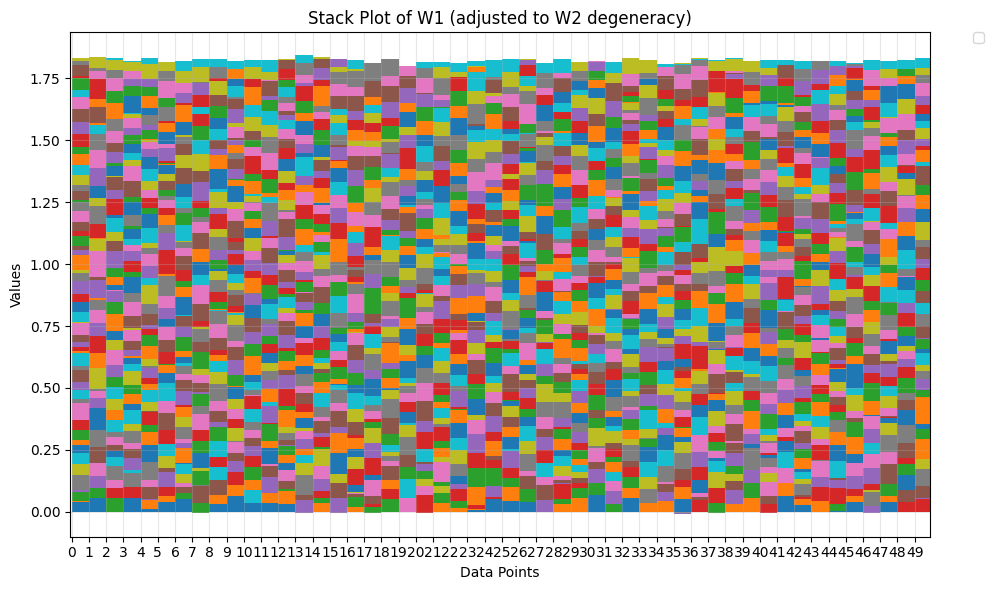

In [82]:
#W1 = model.W1[0].detach().squeeze()
    
def count_above_threshold(matrix, threshold):
    row_counts = (matrix > threshold).sum(dim=1)
    col_counts = (matrix > threshold).sum(dim=0)
    return row_counts, col_counts

#W2 = model.W2[0].detach().squeeze()
#print(count_above_threshold(W1, 0.01))
W1_adj = t.empty_like(W1)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        #print(i,j)
        W1_adj[i][j] = W1[i][j] * W2[j][i]

print(W1_adj.shape)
print(count_above_threshold(W1_adj,0.01))
#print(W1.shape, W2.shape)
plot_polysemanticity(W1_adj, do_thres = False)

In [77]:
positives = [sum([W1[j,i]*W2[i][j] for i in range(n_hidden) if W2[i][j] > 0]) for j in range(n_feat)]
negatives = [sum([W1[j,i]*W2[i][j] for i in range(n_hidden) if W2[i][j] < 0]) for j in range(n_feat)]
sums = [positives[i] + negatives[i] for i in range(n_feat)]
print(positives)
print(negatives)
print(sums)

[tensor(0.9227), tensor(0.9383), tensor(0.9199), tensor(0.9919), tensor(0.9393), tensor(0.9503), tensor(0.9640), tensor(0.9568), tensor(0.9423), tensor(0.9486), tensor(0.9364), tensor(0.9412), tensor(0.9374), tensor(0.9349), tensor(0.9329), tensor(0.9547), tensor(0.9434), tensor(0.9358), tensor(0.9719), tensor(0.9632), tensor(0.9676), tensor(0.9484), tensor(0.9529), tensor(0.9630), tensor(0.9562), tensor(0.9674), tensor(0.9362), tensor(0.9831), tensor(0.9699), tensor(0.9584), tensor(0.9191), tensor(0.9285), tensor(0.9176), tensor(0.9165), tensor(0.9424), tensor(0.9369), tensor(0.9538), tensor(0.9635), tensor(0.9544), tensor(0.9635), tensor(0.9321), tensor(0.9491), tensor(0.9338), tensor(0.9533), tensor(0.9222), tensor(0.9559), tensor(0.9418), tensor(0.9262), tensor(0.9537), tensor(0.9318), tensor(0.9709), tensor(0.9668), tensor(0.9446), tensor(0.9333), tensor(0.9777), tensor(0.9252), tensor(0.9502), tensor(0.9554), tensor(0.9409), tensor(0.9523), tensor(0.9332), tensor(0.9327), tensor(

tensor(0.9050)


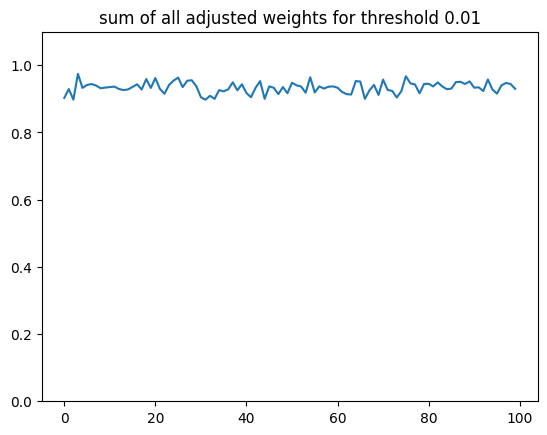

In [80]:
thr = 0.01
counts = [sum([W1_adj[i][j] for j in range(n_hidden) if abs(W1_adj[i][j]) > thr]) for i in range(n_feat)]
plt.plot(counts)
plt.ylim(0,1.1)
plt.title(f"sum of all adjusted weights for threshold {thr}")
print(counts[30])

tensor(-3.8586)
tensor(94.8694)


C:\Users\gigle\AppData\Local\Temp\ipykernel_42420\4263092405.py:29: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



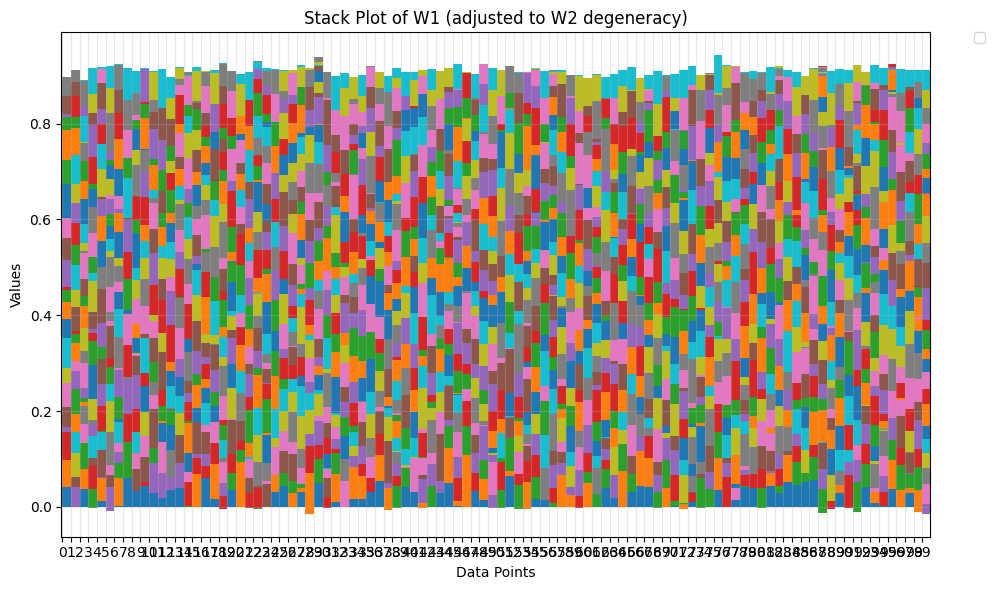

In [76]:

print(t.sum(W1_adj[W1_adj < 0]))
print(t.sum(W1_adj[W1_adj > 0]))
plot_polysemanticity(W1_adj, transpose=True, do_thres=False)


In [43]:
print(W1_adj[2])
#print(model.W2)

tensor([ 3.7953e-02,  4.1422e-02,  5.7707e-02, -1.1126e-05, -3.1418e-03,
        -4.8796e-05,  3.9718e-02,  4.3300e-02, -5.2977e-03, -1.8627e-03,
         3.4805e-05,  9.0644e-03,  9.1953e-03, -2.5635e-04,  2.0528e-02,
        -4.2242e-04,  5.2227e-02,  2.4547e-02,  5.1812e-02, -2.4303e-03,
        -5.8026e-04,  4.5373e-02,  2.5583e-02, -9.3793e-04, -3.6704e-03,
         3.5404e-02,  5.4377e-02,  3.8664e-03,  1.8068e-02,  3.9547e-02,
         5.1598e-02,  3.7106e-02,  4.3602e-02, -6.6999e-04, -1.2986e-03,
         5.3870e-04,  8.5539e-05,  3.8317e-02,  2.4742e-04,  5.9599e-02,
        -2.6836e-03,  2.5189e-05,  5.3979e-04, -1.3051e-03,  2.6312e-02,
        -5.1191e-03, -3.2488e-04,  5.3686e-02, -1.3214e-03,  4.6293e-06])


In [31]:
def count_represented_features(n_feat, model, threshold = 0.01) -> int:
    count = 0
    losses_sep = []
    losses_stat = []
    with t.no_grad():
        for i in range(n_feat):
            x = t.zeros(n_feat)
            x[i] = 1
            x = t.reshape(x, [1,1,x.shape[0]])
            y = model.forward(x)
            loss = model.calculate_loss(x,y)
            losses_sep.append(loss)
            #y.squeeze(0).squeeze(0)
            y = y[0][0]
            #print(y.shape)
            if t.abs(y[i] - 1.0).item() < threshold:
                count += 1
            stats = []
            y[i] = 0
            stats.append(max(y))
            stats.append(min(y))
            stats.append(len([_ for i in range(n_feat) if t.abs(y[i] - 1.0).item() < 0.5]))
            y = abs(y)
            stats.append(sum(y))

            losses_stat.append(stats)
        return (count, losses_sep, losses_stat)

In [75]:
def plot_polysemanticity(W1, transpose = False, do_thres = True):
    import matplotlib.pyplot as plt
    W1 = W1.clone()
    if transpose:
        W1 = W1.T
    # Define the weight matrix
    #W1 = model.W1.detach().numpy().squeeze()
    if do_thres:
        W1 = threshold_matrix(W1)

    # Create feature labels
    features = [f'Feature {i+1}' for i in range(W1.shape[0])]

    # Extend x range by one point to show the last step
    x = np.arange(W1.shape[1] + 1)
    # Extend the weight matrix data by repeating the last column
    W1_extended = np.hstack([W1, W1[:, -1:]])

    # Create larger figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create stack plot with extended data
    #ax.stackplot(x, W1_extended, labels=features, step='post')
    ax.stackplot(x, W1_extended, step='post')
    ax.set_xlim(-0.1, W1.shape[1] - 0.1)  # Set limit to show exactly 6 stacks

    # Enhance visibility
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

    # Set titles and labels
    ax.set_title('Stack Plot of W1 (adjusted to W2 degeneracy)')
    ax.set_xlabel('Data Points')
    ax.set_ylabel('Values')

    # Add x-ticks for each neuron
    ax.set_xticks(np.arange(W1.shape[1]))
    #ax.set_xticklabels([f'Neuron {i+1}' for i in range(W1.shape[1])])

    # Adjust layout to prevent cutoff
    plt.tight_layout()

    # Show the plot
    plt.show()

In [9]:
def threshold_matrix(matrix, threshold=0.01):
    """
    Sets matrix elements to zero if their absolute value is below the threshold.
    
    Args:
        matrix: Input numpy array
        threshold: Values below this threshold will be set to 0 (default: 1e-10)
    
    Returns:
        numpy array with small values set to zero
    """
    # Create a copy to avoid modifying the original matrix
    result = np.copy(matrix)
    
    # Set elements below threshold to zero
    result[np.abs(result) < threshold] = 0
    
    return result

In [86]:
#t.save({'W1': model.W1.detach(), 'W2': model.W2.detach()}, 'weighted_mse.pt')

In [45]:
def pca_2d(data):
    """
    Perform PCA on high-dimensional data and project to 2D.
    
    Args:
        data (torch.Tensor): Input tensor of shape (n_samples, n_features)
        
    Returns:
        torch.Tensor: Projected data of shape (n_samples, 2)
    """
    # Center the data
    mean = t.mean(data, dim=0)
    centered_data = data - mean

    # Compute covariance matrix
    cov = t.mm(centered_data.T, centered_data) / (data.shape[0] - 1)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = t.linalg.eigh(cov)
    
    # Sort eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = t.argsort(eigenvalues, descending=True)
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    # Select top 2 eigenvectors
    projection_matrix = eigenvectors[:, :2]
    
    # Project the data
    projected_data = t.mm(centered_data, projection_matrix)
    
    return projected_data, eigenvalues

def visualize_pca(projected_data, title="PCA Projection", colors=None):
    """
    Visualize the PCA projection in 2D.
    
    Args:
        projected_data (torch.Tensor): PCA-projected data of shape (n_samples, 2)
        title (str): Plot title
        colors (list, optional): List of colors for different data points
    """
    plt.figure(figsize=(10, 8))
    
    # Convert to numpy for plotting
    data_np = projected_data.numpy()
    
    if colors is None:
        plt.scatter(data_np[:, 0], data_np[:, 1], alpha=0.7)
    else:
        plt.scatter(data_np[:, 0], data_np[:, 1], c=colors, alpha=0.7)
    
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title(title)
    plt.grid(True)
    plt.show()

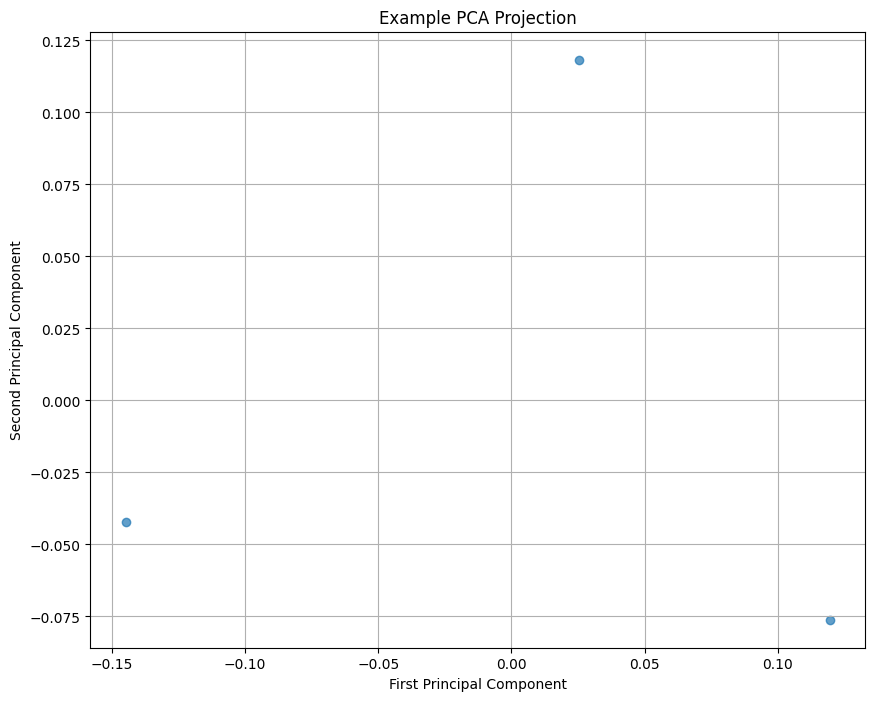

Explained variance ratio: [0.6249424  0.37505767]


In [62]:
projected_data, eigenvalues = pca_2d(W1_adj[11:14])
visualize_pca(projected_data, "Example PCA Projection")
explained_variance_ratio = eigenvalues[:2] / t.sum(eigenvalues)
print(f"Explained variance ratio: {explained_variance_ratio.numpy()}")

In [84]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

def pca_projection(data, n_components=2):
    """
    Perform PCA on high-dimensional data and project to n_components dimensions.
    
    Args:
        data (torch.Tensor): Input tensor of shape (n_samples, n_features)
        n_components (int): Number of components to project to (2 or 3)
        
    Returns:
        torch.Tensor: Projected data of shape (n_samples, n_components)
        torch.Tensor: Eigenvalues
    """
    # Center the data
    mean = t.mean(data, dim=0)
    centered_data = data - mean

    # Compute covariance matrix
    cov = t.mm(centered_data.T, centered_data) / (data.shape[0] - 1)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = t.linalg.eigh(cov)
    
    # Sort eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = t.argsort(eigenvalues, descending=True)
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    # Select top n_components eigenvectors
    projection_matrix = eigenvectors[:, :n_components]
    
    # Project the data
    projected_data = t.mm(centered_data, projection_matrix)
    
    return projected_data, eigenvalues

def visualize_pca(projected_data, title="PCA Projection", colors=None):
    """
    Visualize the PCA projection in 2D or 3D using plotly.
    
    Args:
        projected_data (torch.Tensor): PCA-projected data of shape (n_samples, 2) or (n_samples, 3)
        title (str): Plot title
        colors (list, optional): List of colors for different data points
    """
    # Convert to numpy
    data_np = projected_data.numpy()
    
    # Create a DataFrame for plotly
    if data_np.shape[1] == 2:
        df = pd.DataFrame(data_np, columns=['PC1', 'PC2'])
        
        if colors is not None:
            df['Color'] = colors.numpy() if isinstance(colors, torch.Tensor) else colors
            fig = px.scatter(df, x='PC1', y='PC2', color='Color',
                           title=title)
        else:
            fig = px.scatter(df, x='PC1', y='PC2', title=title)
            
    elif data_np.shape[1] == 3:
        df = pd.DataFrame(data_np, columns=['PC1', 'PC2', 'PC3'])
        
        if colors is not None:
            df['Color'] = colors.numpy() if isinstance(colors, torch.Tensor) else colors
            fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='Color',
                              title=title)
        else:
            fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', title=title)
    
    # Update layout for better visualization
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,
            xanchor='center'
        ),
        width=800,  # Set width
        height=800,  # Set equal height for square aspect ratio
        scene=dict(
            xaxis_title='First Principal Component',
            yaxis_title='Second Principal Component',
            zaxis_title='Third Principal Component' if data_np.shape[1] == 3 else None,
            aspectmode='cube'  # Force equal aspect ratio for all axes
        ),
        template='plotly_white'
    )
    
    # Show the plot
    fig.show()

In [85]:
projected_data_2d, eigenvalues = pca_projection(W1_adj[16:19], n_components=2)
visualize_pca(projected_data_2d, "2D PCA Projection")
projected_data_3d, eigenvalues = pca_projection(W1_adj[16:20], n_components=3)
visualize_pca(projected_data_3d, "3D PCA Projection")
